
# CIFAR-10 Classification



Import Statements

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
from skimage.transform import rotate, AffineTransform, warp
import pandas as pd
from sklearn.model_selection import KFold

In [7]:
plt.rcParams['figure.figsize'] = (20, 10)

Load the Dataset

In [3]:
cifar10 = tf.keras.datasets.cifar10
[X_train, Y_train],[X_test, Y_test] = cifar10.load_data()
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()
X_train = X_train[..., None]
X_test = X_test[..., None]

Y_train_oh = np.zeros((Y_train.size, 10)) # make 2D array with same num of rows as y_train but each digit has its own array with a length of 10
Y_train_oh[np.arange(Y_train.size), Y_train] = 1 # fills each array with its corresponding index of Y_train being 1
Y_test_oh = np.zeros((Y_test.size, 10))
Y_test_oh[np.arange(Y_test.size), Y_test] = 1

print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)
print('Y_train_oh:', Y_train_oh.shape)
print('X_test:', X_test.shape)
print('Y_test:', Y_test.shape)
print('Y_test_oh:', Y_test_oh.shape)

x_train = X_train.reshape(-1, 32*32)
x_test = X_test.reshape(-1, 32*32)

print('x_train:', x_train.shape)

X_train: (50000, 32, 32, 3, 1)
Y_train: (50000,)
Y_train_oh: (50000, 10)
X_test: (10000, 32, 32, 3, 1)
Y_test: (10000,)
Y_test_oh: (10000, 10)
x_train: (150000, 1024)


Transform the Dataset

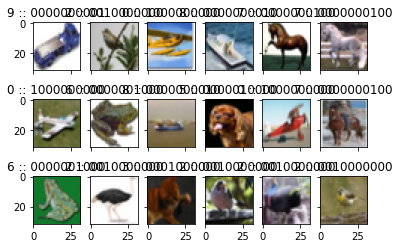

In [25]:
fig, AX = plt.subplots(3, 6, sharex=True, sharey=True)

np.random.seed(1234) # set a random seed
for ax in AX.ravel(): # turns AX into a 1D array and loops through it
    rindex = np.random.randint(Y_train.size) # assigns rindex to a random number between 0 and 60000
    img_show = X_train[rindex][...,0] # assings img_show to a random img in X_train
    ax.imshow(img_show, cmap='gray')
    # title label + one-hot
    title = f'{Y_train[rindex]} :: '
    title += ''.join([str(int(e)) for e in Y_train_oh[rindex]]) 
    ax.set_title(title)
plt.grid(False)

Classification Using Shallow Neural Network

In [ ]:
EPOCHS = 10
BATCH = 500
E = 100

neurons = 2048

m, n_x = x_train.shape

model = tf.keras.Sequential([
  tf.keras.layers.Input(n_x),
  tf.keras.layers.Dense(neurons, activation='relu'),
  tf.keras.layers.Dense(1024, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

loss_plot = []; accA_plot = []

for epoch in range(EPOCHS + 1):
    # randomic batch definition
    rbatch = np.random.choice(Y_train.size, size=BATCH, replace=False)
    # training, metrics and storage
    model.fit(x_train[rbatch], Y_train_oh[rbatch], epochs=E, verbose=0) # trains model for the number of epochs we set earlier
    loss_plot += [e*100 for e in model.history.history['loss']] # get loss data and add the info to a loss_plot
    accA_plot += [e*100 for e in model.history.history['accuracy']] # get accuracy data and add thte info to a accuracy plot
    if (not epoch % (EPOCHS//5)) and (epoch != 0):
        print(f'epoch: {epoch*E:04d} | loss: {loss_plot[-1]:.3f} | accuracy: {accA_plot[-1]:06.2f} %') # prints the most recent data added to the loss plot

In [ ]:
fig, [axA, axB] = plt.subplots(2, 1, sharex=True)

axA.plot(loss_plot)
axA.set_ylabel('loss')
axB.plot(accA_plot)
axB.set_ylabel('accuracy')

plt.xlabel('epochs')

plt.show()

In [ ]:
fig, AX = plt.subplots(5, 10, sharex=True)
AX = [b for a in AX for b in a]

pred = model.predict(x_test) # test the model on new data

np.random.seed(1234)
for ax in AX:
    index = np.random.randint(Y_test.size) # random number bettween 0 and 10000 (size of Y_test)
    # Predict
    A_ = pred[index]
    Y_ = np.argmax(A_) # get the last index of A_ (aka the digit the ai thinks the picture represents)
    # Prepare image to show
    img_show = np.ones((*x_test[index].shape, 3))
    img_show *= x_test[index][..., None]
    img_show = img_show.reshape(32, 32, 3)
    # Green square: classified correctly
    # Red square: classified wrongly
    if Y_ == Y_test[index]:
        img_show[-4:, -4:] = (0, 1, 0)
    else:
        img_show[-4:, -4:] = (1, 0, 0)
    ax.imshow(img_show)
    ax.set_title(r'$\hat{Y_i}$ = ' + str(Y_) + r' ; $A_i$ = {:.02f}'.format(float(A_[Y_])), fontsize=10)

# Convolutional Neural Network

In [6]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

num_classes = 10

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# Checking the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [7]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

# KFold Cross Validation

In [163]:
n_split = 10

csv_logger = tf.keras.callbacks.CSVLogger('training3.log', separator=',', append=False)

loss_plot = []
accA_plot = []

# K-fold cross validation
for train_index, test_index in KFold(n_split).split(X_train):
    model.fit(X_train[train_index], Y_train_oh[train_index], epochs=1, verbose=0, callbacks=[csv_logger])
    test_loss, test_acc = model.evaluate(X_train[test_index], Y_train_oh[test_index], verbose=2)
    print(test_index[0], '-', test_index[-1], 'Test accuracy:', test_acc)
    print(test_index[0], '-', test_index[-1], 'Test loss:', test_loss)
    loss_plot += [test_loss*100]
    accA_plot += [test_acc*100]

model.save('model.h5')

157/157 - 3s - loss: 0.3133 - accuracy: 0.8900 - 3s/epoch - 22ms/step
0 - 4999 Test accuracy: 0.8899999856948853
0 - 4999 Test loss: 0.31329458951950073
157/157 - 4s - loss: 0.3369 - accuracy: 0.8824 - 4s/epoch - 23ms/step
5000 - 9999 Test accuracy: 0.8823999762535095
5000 - 9999 Test loss: 0.33692991733551025
157/157 - 3s - loss: 0.3822 - accuracy: 0.8690 - 3s/epoch - 20ms/step
10000 - 14999 Test accuracy: 0.8690000176429749
10000 - 14999 Test loss: 0.38217779994010925
157/157 - 3s - loss: 0.2973 - accuracy: 0.8982 - 3s/epoch - 18ms/step
15000 - 19999 Test accuracy: 0.8981999754905701
15000 - 19999 Test loss: 0.2972649931907654
157/157 - 3s - loss: 0.3082 - accuracy: 0.8830 - 3s/epoch - 18ms/step
20000 - 24999 Test accuracy: 0.8830000162124634
20000 - 24999 Test loss: 0.3082188069820404
157/157 - 3s - loss: 0.2551 - accuracy: 0.9092 - 3s/epoch - 18ms/step
25000 - 29999 Test accuracy: 0.9092000126838684
25000 - 29999 Test loss: 0.25508204102516174
157/157 - 3s - loss: 0.2637 - accuracy

### Testing the Model

In [15]:
model = tf.keras.models.load_model('model.h5')

In [16]:
model.evaluate(X_test, Y_test_oh)

313/313 [==============================] - 8s 23ms/step - loss: 0.4402 - accuracy: 0.8549


[0.4402267038822174, 0.8549000024795532]

In [17]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
pred = model.predict(X_test)

pred_classes = np.argmax(pred, axis=1)

313/313 [==============================] - 7s 22ms/step


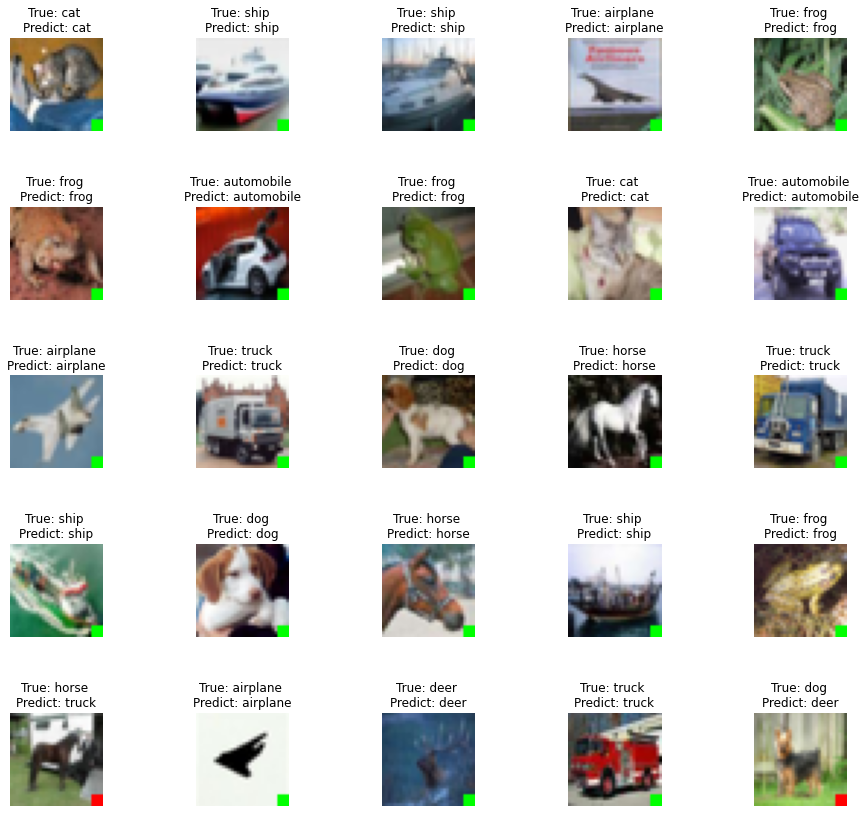

In [28]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    if class_names[pred_classes[i]] == class_names[Y_test[i][0]]:
        X_test[i][-4:, -4:] = (0, 255, 0)
    else:
        X_test[i][-4:, -4:] = (255, 0, 0)

    axes[i].imshow(X_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[Y_test[i][0]], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [29]:
model_data = pd.read_csv('training3.log', sep=',', engine='python')

In [30]:
plt.plot(accA_plot, label='loss')
plt.plot(loss_plot, label='acc')
plt.legend()
plt.show()

NameError: name 'accA_plot' is not defined

### Image Rotations

In [4]:
x_vflip = np.flip(X_train, 1)
x_hflip = np.flip(X_train, 2)

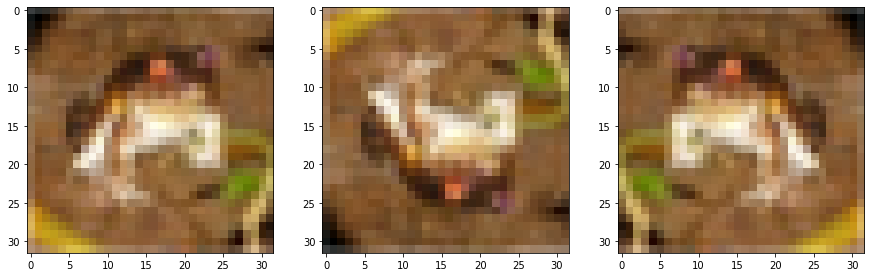

In [143]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))

axes[0].imshow(X_train[0])
axes[1].imshow(x_vflip[0])
axes[2].imshow(x_hflip[0])

In [5]:
X_augmented = np.concatenate((X_train, x_vflip, x_hflip), axis=0)
X_test_augmented = np.concatenate((X_test, np.flip(X_test, 1), np.flip(X_test, 2)), axis=0)

In [6]:
Y_augmented = np.concatenate((Y_train_oh, Y_train_oh, Y_train_oh), axis=0)
Y_test_augmented = np.concatenate((Y_test_oh, Y_test_oh, Y_test_oh), axis=0)

In [7]:
num_classes = 10

model2 = tf.keras.Sequential()

model2.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Dropout(0.5))

model2.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(tf.keras.layers.Dropout(0.5))

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# Checking the model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [8]:
model2.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
loss_plot2 = []
accA_plot2 = []

In [159]:
n_split = 10

csv_logger = tf.keras.callbacks.CSVLogger('training3.log', separator=',', append=False)

# K-fold cross validation
for train_index, test_index in KFold(n_split).split(X_augmented):
    model2.fit(X_augmented[train_index], Y_augmented[train_index], epochs=1, verbose=0, callbacks=[csv_logger])
    test_loss, test_acc = model2.evaluate(X_augmented[test_index], Y_augmented[test_index], verbose=2)
    print(test_index[0], '-', test_index[-1], 'Test accuracy:', test_acc)
    print(test_index[0], '-', test_index[-1], 'Test loss:', test_loss)
    loss_plot2 += [test_loss*100]
    accA_plot2 += [test_acc*100]

model.save('model2.h5')

469/469 - 8s - loss: 0.8236 - accuracy: 0.7094 - 8s/epoch - 17ms/step
0 - 14999 Test accuracy: 0.7093999981880188
0 - 14999 Test loss: 0.8236375451087952
469/469 - 9s - loss: 0.7132 - accuracy: 0.7546 - 9s/epoch - 19ms/step
15000 - 29999 Test accuracy: 0.7545999884605408
15000 - 29999 Test loss: 0.7132114171981812
469/469 - 9s - loss: 0.7560 - accuracy: 0.7409 - 9s/epoch - 20ms/step
30000 - 44999 Test accuracy: 0.740933358669281
30000 - 44999 Test loss: 0.7560175061225891
469/469 - 9s - loss: 0.6520 - accuracy: 0.7671 - 9s/epoch - 19ms/step
45000 - 59999 Test accuracy: 0.7670666575431824
45000 - 59999 Test loss: 0.651953399181366
469/469 - 9s - loss: 0.7545 - accuracy: 0.7304 - 9s/epoch - 19ms/step
60000 - 74999 Test accuracy: 0.730400025844574
60000 - 74999 Test loss: 0.7544705867767334
469/469 - 14s - loss: 0.7746 - accuracy: 0.7289 - 14s/epoch - 30ms/step
75000 - 89999 Test accuracy: 0.7289333343505859
75000 - 89999 Test loss: 0.7745880484580994
469/469 - 9s - loss: 0.5587 - accurac

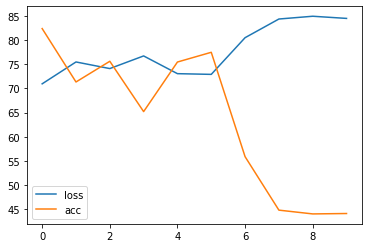

In [172]:
plt.plot(accA_plot2, label='loss')
plt.plot(loss_plot2, label='acc')
plt.legend()
plt.show()

In [160]:
model2.evaluate(X_test, Y_test_oh)

313/313 [==============================] - 7s 22ms/step - loss: 0.5178 - accuracy: 0.8217


[0.5178011655807495, 0.8216999769210815]

In [167]:
model2.evaluate(X_test_augmented, Y_test_augmented)

938/938 [==============================] - 19s 20ms/step - loss: 0.5595 - accuracy: 0.8043


[0.5595382452011108, 0.8042666912078857]

In [170]:
model = tf.keras.models.load_model('model.h5')

model.evaluate(X_test_augmented, Y_test_augmented)

938/938 [==============================] - 19s 20ms/step - loss: 1.1068 - accuracy: 0.6954


[1.106818437576294, 0.6954333186149597]

In [ ]:
n_split = 10

csv_logger = tf.keras.callbacks.CSVLogger('training3.log', separator=',', append=False)

# K-fold cross validation
for train_index, test_index in KFold(n_split).split(X_augmented):
    model2.fit(X_augmented[train_index], Y_augmented[train_index], epochs=1, verbose=0, callbacks=[csv_logger])
    test_loss, test_acc = model2.evaluate(X_augmented[test_index], Y_augmented[test_index], verbose=2)
    print(test_index[0], '-', test_index[-1], 'Test accuracy:', test_acc)
    print(test_index[0], '-', test_index[-1], 'Test loss:', test_loss)
    loss_plot2 += [test_loss*100]
    accA_plot2 += [test_acc*100]

model.save('model2.h5')